In [1527]:
from skimage import img_as_float
import matplotlib.pyplot as plt
import numpy as np

def imshow_all(*images, titles=None):
    images = [img_as_float(img) for img in images]

    if titles is None:
        titles = [''] * len(images)
    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    ncols = len(images)
    height = 10
    width = height * len(images)
    fig, axes = plt.subplots(nrows=1, ncols=ncols,
                             figsize=(width, height))
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, vmin=vmin, vmax=vmax,cmap="gray")
        ax.set_title(label)

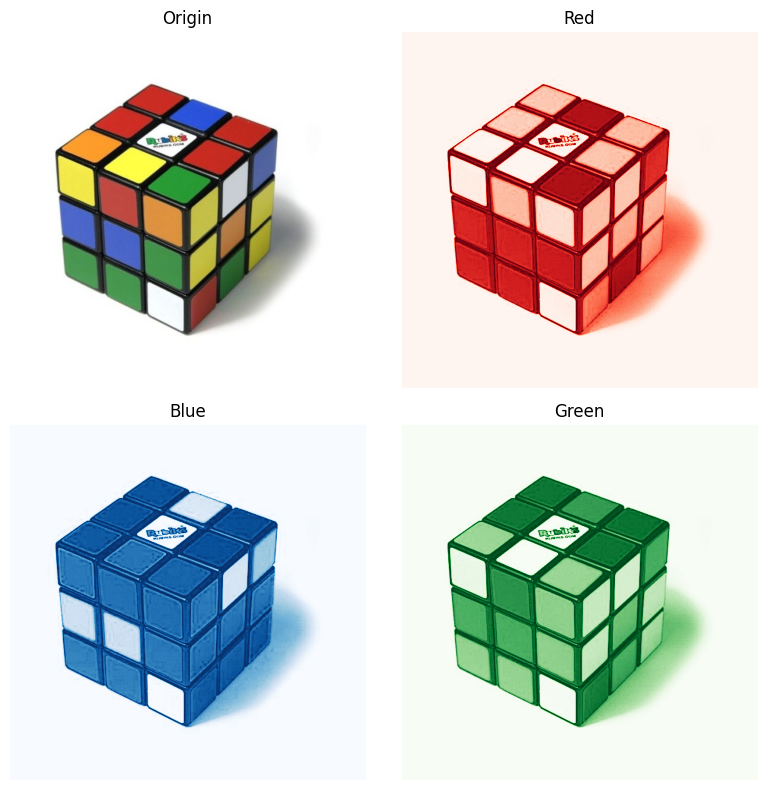

In [1528]:
import cv2

import random as rng
from scipy import ndimage as ndi

input_image = cv2.imread('images/square6.jpg')
black_back_image = 255 - input_image

blue, green, red = cv2.split(black_back_image)

# high pass per il colore rosso -> evidenziazione dei bordi della immagine 
blur = cv2.GaussianBlur(red, (9,9), 0)
high_pass = cv2.subtract(red, blur)
high_pass = cv2.convertScaleAbs(high_pass, alpha = 3.0)
# combinazione high pass con l'immagine originale rossa
red = cv2.add(red, high_pass)

# high pass per il colore blu -> evidenziazione dei bordi della immagine 
blur = cv2.GaussianBlur(blue, (9,9), 0)
high_pass = cv2.subtract(blue, blur)
high_pass = cv2.convertScaleAbs(high_pass, alpha = 3.0)
# combinazione high pass con l'immagine originale blu
blue = cv2.add(blue, high_pass)

# high pass per il colore verde -> evidenziazione dei bordi della immagine 
blur = cv2.GaussianBlur(green, (9,9), 0)
high_pass = cv2.subtract(green, blur)
high_pass = cv2.convertScaleAbs(high_pass, alpha = 3.0)
# combinazione high pass con l'immagine originale verde
green = cv2.add(green, high_pass)


plt.figure(figsize=(8, 8))

# Prima immagine
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
plt.title('Origin')
plt.axis('off')

# Seconda immagine
plt.subplot(2, 2, 2)
plt.imshow(red, cmap='Reds')
plt.title('Red')
plt.axis('off')

# Terza immagine
plt.subplot(2, 2, 3)
plt.imshow(blue, cmap='Blues')
plt.title('Blue')
plt.axis('off')

# Quarta immagine
plt.subplot(2, 2, 4)
plt.imshow(green, cmap='Greens')
plt.title('Green')
plt.axis('off')

plt.tight_layout()  # Aggiunge spaziatura tra le immagini per una migliore visualizzazione
plt.show()

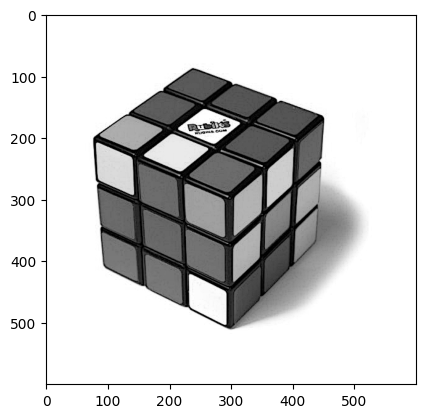

In [1529]:
# Unione dei colori
from skimage.morphology import square
from skimage import filters

HP_gray_image = 255 - cv2.cvtColor(cv2.merge([blue, green, red],), cv2.COLOR_BGR2GRAY) # immagine High Pass in B/W
plt.imshow(HP_gray_image,cmap="gray")

In [1530]:
adaptive_gaussian = cv2.adaptiveThreshold(HP_gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, 7) 

In [1531]:
resized = cv2.resize(adaptive_gaussian, (300, 300), interpolation = cv2.INTER_AREA)

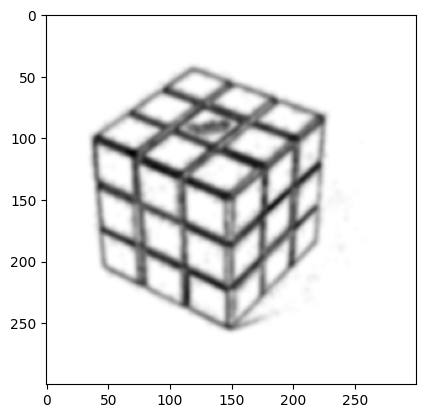

In [1532]:
smooth = filters.gaussian(resized, sigma=2)
plt.imshow(smooth,cmap="gray")

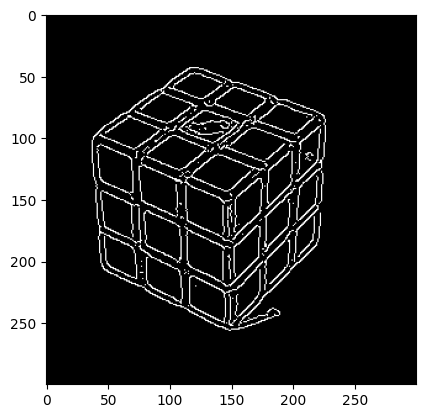

In [1533]:
smooth *= 255/smooth.max() 
smooth = np.array(smooth, np.uint8)


lower = 10
upper = lower*3
canny = cv2.Canny(smooth,lower,upper)
plt.imshow(canny,cmap="gray")

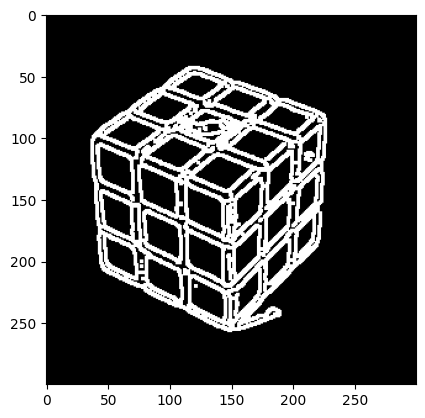

In [1534]:
kernel = np.ones((3,3),np.uint8)
dilatated = cv2.dilate(canny,kernel,iterations = 1)
plt.imshow(dilatated,cmap="gray")

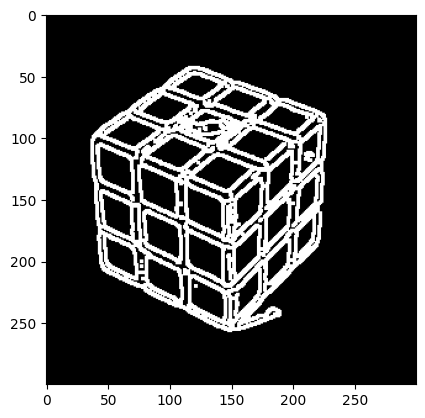

In [1535]:
thickness = 50

cv2.line(dilatated, (0,0), (0,300), (0,0,0), thickness)
cv2.line(dilatated, (0,300), (300,300), (0,0,0), thickness)
cv2.line(dilatated, (300,300), (300,0), (0,0,0), thickness)
cv2.line(dilatated, (300,0), (0,0), (0,0,0), thickness)

plt.imshow(dilatated,cmap="gray")

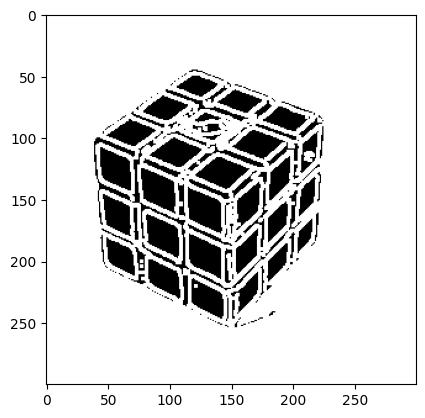

In [1536]:
seed_point = (0, 0)
new_color = (255,255,255)

cv2.floodFill(dilatated, None, seed_point, new_color)

plt.imshow(dilatated,cmap="gray")

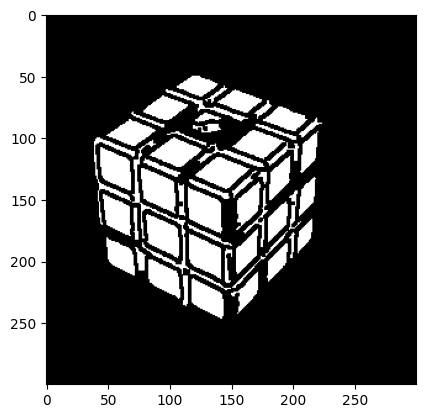

In [1537]:
contours, _ = cv2.findContours(255-dilatated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_area = 20
filtered_image = np.zeros_like(dilatated)
for contour in contours:
    area = cv2.contourArea(contour)
    if area >= min_area:
        cv2.drawContours(filtered_image, [contour], -1, 255, thickness=cv2.FILLED)

plt.imshow(filtered_image,cmap="gray")

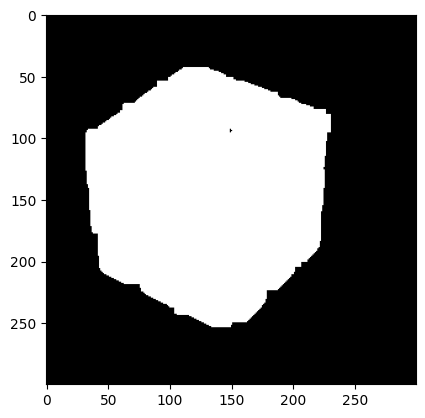

In [1538]:
kernel = np.ones((3,3),np.uint8)
erosion = cv2.dilate(filtered_image,kernel,iterations = 7)
plt.imshow(erosion,cmap="gray")

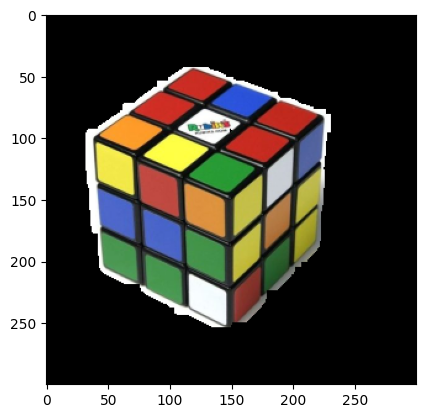

In [1539]:
tmp = cv2.resize(input_image, (300, 300), interpolation = cv2.INTER_AREA)
result_image = cv2.bitwise_and(tmp, tmp, mask=erosion)
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))

Numero di contorni trovati: 1
Area = 31194.0


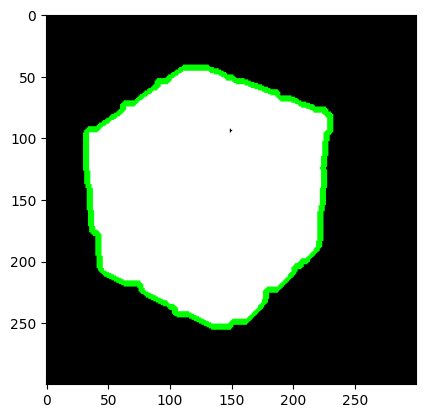

In [1540]:
contours, _ = cv2.findContours(erosion, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"Numero di contorni trovati: {len(contours)}")
print(f"Area = {cv2.contourArea(contours[0])}")

tmp = cv2.cvtColor(erosion,cv2.COLOR_GRAY2RGB)
cv2.drawContours(tmp, contours, -1, (0, 255, 0), thickness = 3)
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

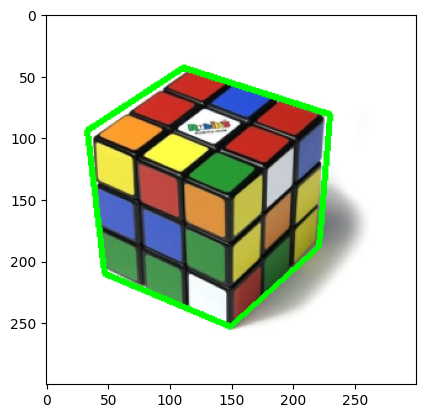

In [1541]:
epsilon = 0.03 * cv2.arcLength(contours[0], True)
approx_polygon = cv2.approxPolyDP(contours[0], epsilon, True)
tmp = cv2.resize(input_image, (300, 300), interpolation = cv2.INTER_AREA)
cv2.drawContours(tmp, [approx_polygon], -1, (0, 255, 0), thickness = 3)
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))